In [15]:
import tensorflow as tf
from tensorflow import keras
import mobilenet_ae_Unet
import matplotlib.pyplot as plt
from tqdm import tqdm
import data_util
import numpy as np

In [2]:
tf.random.set_seed(42)

mse = keras.losses.MeanSquaredError()
mae = keras.losses.MeanAbsoluteError()
be = keras.losses.BinaryCrossentropy()

In [3]:
def custom_loss(x, x_recon):
    loss = mae(x, x_recon)
    return loss

In [4]:
@tf.function
def train_step(x, model, optimizer):
    with tf.GradientTape() as tape:
        recon = model(x)
        loss = custom_loss(x, recon)
    gradients = tape.gradient(loss, model.trainable_variables)
    optimizer.apply_gradients(zip(gradients, model.trainable_variables))

    return recon

In [5]:
def save_image(model, sample, epoch):
    sample = ae(sample)
    for i in range(4):
        ax = plt.subplot(2, 2, i + 1)
        plt.imshow((sample[i].numpy() + 1) / 2)
        plt.axis('off')

    plt.savefig('./train_image/image_at_epoch_{:04d}.png'.format(epoch))
    plt.clf()
    plt.close()

In [6]:
input_size = (224, 224, 3)
batch_size = 32

ae = mobilenet_ae_Unet.MobileNetV2_UNet().build_model(20)

In [7]:
train_ds = data_util.get_autoencoder_dataset(batch_size=batch_size)

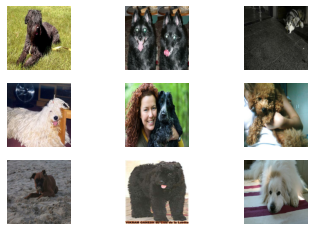

In [11]:
for images in train_ds.take(1):
    for i in range(9):
        ax = plt.subplot(3, 3, i + 1)
        plt.imshow((images[i].numpy() + 1) / 2)
        plt.axis('off')

In [12]:
sample = None
for t in train_ds.take(1):
    sample = t
sample.shape

TensorShape([32, 224, 224, 3])

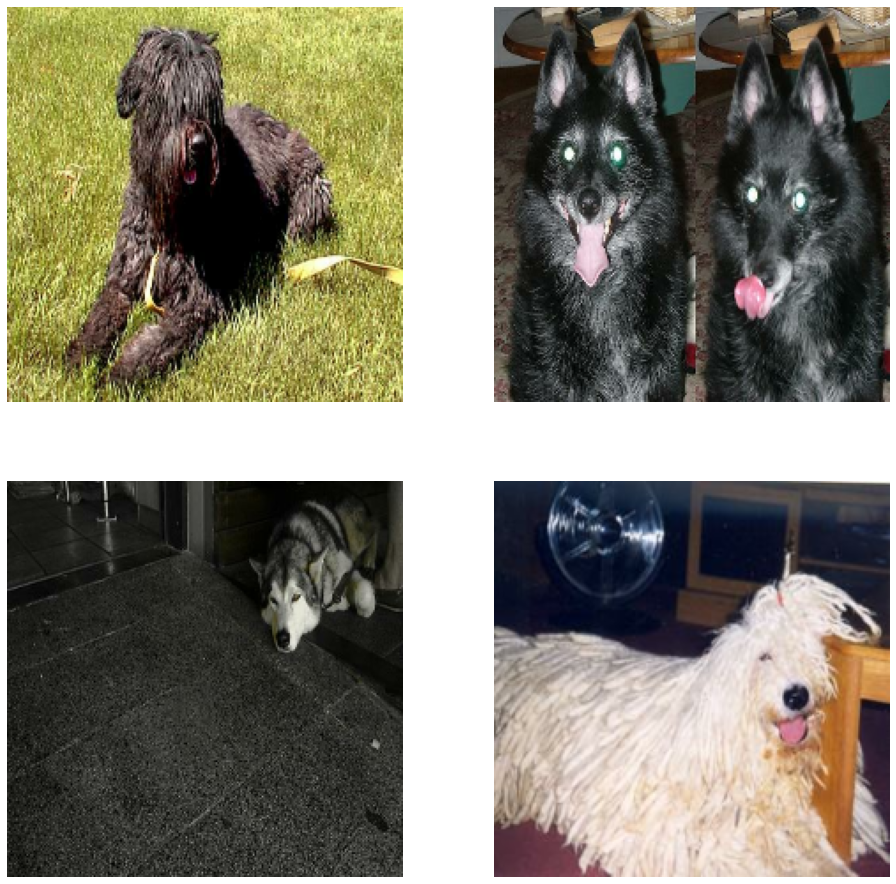

In [13]:
plt.figure(figsize=(16, 16))
for i in range(4):
    ax = plt.subplot(2, 2, i + 1)
    plt.imshow((sample[i].numpy() + 1) / 2)
    plt.axis('off')

In [14]:
optimizer = keras.optimizers.Adam()
epochs = 100

ckpt_path = './ckpt/mobileNetAE_'
best_loss = np.inf
best_epoch = 0

NameError: name 'np' is not defined

In [12]:
hist = []
for epoch in range(1, epochs + 1):
    train_loss = tf.keras.metrics.Mean()
    for train_x in tqdm(train_ds, desc=str(epoch)):
        recon = train_step(train_x, ae, optimizer)
        train_loss(mae(train_x, recon))

    if train_loss.result() < best_loss:
        best_loss = train_loss.result()
        best_epoch = epoch
        ae.save_weights(ckpt_path + str(epoch))
    print('epoch {} train loss {} '.format(epoch, train_loss.result()))
    print('best loss {} best epoch {}'.format(best_loss, best_epoch))
    print()
    hist.append(train_loss.result())
    if epoch % 100 == 0 or epoch == 1:
        save_image(ae, sample, epoch)

1: 0it [00:38, ?it/s]


KeyboardInterrupt: 

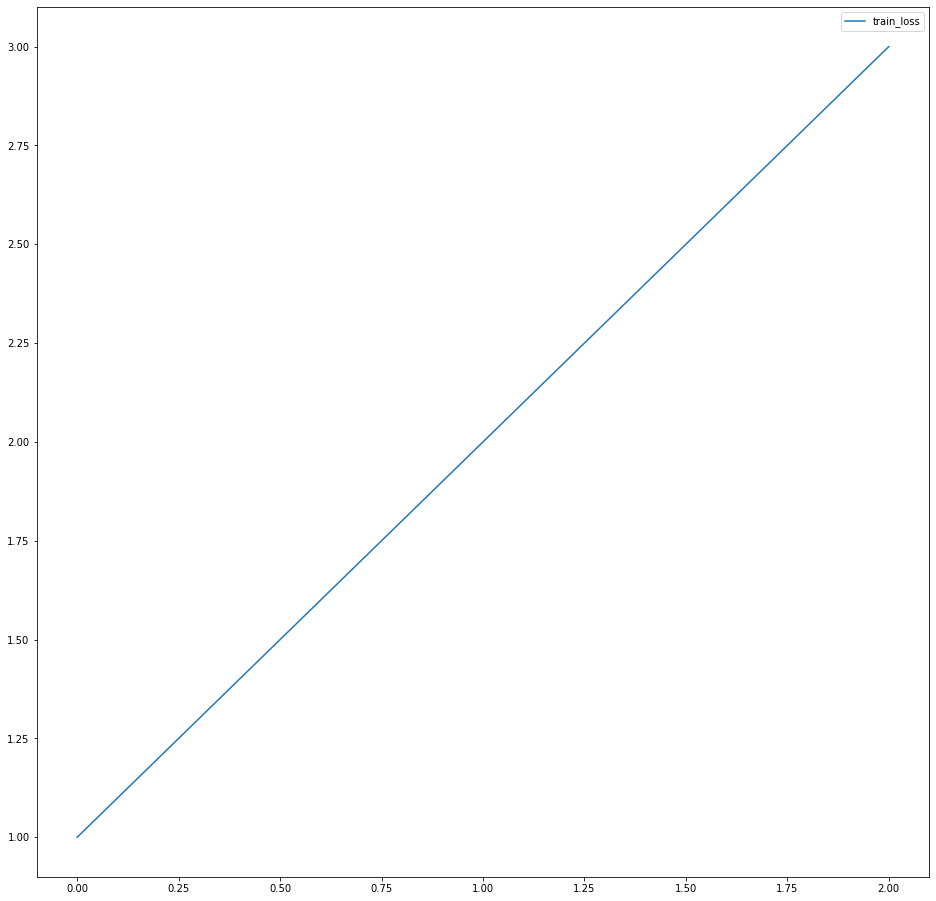

In [10]:
plt.figure(figsize=(16, 16))
plt.plot(hist, label='train_loss')
plt.legend()
# plt.savefig('./AE_train_loss.png')